In [60]:

import numpy as np
import segyio
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.signal import butter, lfilter
from ipywidgets import Button, HBox, VBox

import matplotlib
import warnings
warnings.filterwarnings('ignore')
from scipy.signal.signaltools import hilbert
import glob
import cmath

#fig, ax = plt.subplots(figsize=(20, 10))


#plt.rcParams["figure.figsize"] = (10,5)


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

#%matplotlib inline
%matplotlib notebook
sourcefile='D:/small.sgy'
sourcefile='D:/Vawn.SGY'
sourcefile="C:/Users/koushb/OneDrive - Husky Energy/ML/ML_S_Int/For GoogleML data/data/Cropped SGY/DV.sgy"
src=segyio.open(sourcefile)

TimeSamples=src.samples

#np_s=readsegy(sourcefile)

il_min=src.ilines[0]
il_max=src.ilines[-1]

xl_min=src.xlines[0]
xl_max=src.xlines[-1]


filter_files=['None']


for file in glob.glob(".\\filters\\*.npz"):
    filter_files.append(file)

 

def readsegy(sourcefile):
    src=segyio.open(sourcefile)
    a=[]
    for inline in src.ilines:
        a.append(np.array(src.iline[inline]).T)
    a=np.array(a)
    a=np.swapaxes(a,0,1)
    return(a)

def traceij(iline,xline):

    ii= np.where(src.ilines == iline)[0][0]
    jj=np.where(src.xlines == xline)[0][0]

    ij=ii*len(src.xlines)+jj
    #checkit
    if src.header[ij][segyio.TraceField.INLINE_3D] != iline :
            raise Exception('Extracted inline does not match with header')
    if src.header[ij][segyio.TraceField.CROSSLINE_3D] != xline :
            raise Exception('Extracted crossline does not match with header')
    return(src.trace[ij])



def do_filter(x):
    file_name=filters.value
    
    data = np.load(file_name, fix_imports=True, encoding='bytes') # array containing dict, dtype 'object'    
    b,a=data['ba']
    for i in range(x.shape[-1]):    
        x[...,i]= lfilter(b, a, x[...,i])
    return(x)


 

In [9]:
# from https://github.com/geopyteam/cognitivegeo/blob/master/cognitivegeo/src/seismic/attribute.py

def calcPhaseShift_trace(x,d):
    #from https://stackoverflow.com/questions/52179919/amplitude-and-phase-spectrum-shifting-the-phase-leaving-amplitude-untouched
    
    phase=d*(np.pi/180)
    signalFFT = np.fft.rfft(x)
    

    ## Get Power Spectral Density
    signalPSD = np.abs(signalFFT) ** 2
    signalPSD /= len(signalFFT)**2

    ## Get Phase
    signalPhase = np.angle(signalFFT)

    ## Phase Shift the signal +90 degrees
    newSignalFFT = signalFFT * cmath.rect( 1., phase )

    ## Reverse Fourier transform
    newSignal = np.fft.irfft(newSignalFFT,x.shape[0])
    return newSignal
def calcPhaseShift(x):
    d=degree.value
    #print(d)
    attrib = x.copy()
    for i in range(x.shape[-1]):    
            attrib[...,i]= calcPhaseShift_trace(x[...,i],d)
    return (attrib)

def calcFirstDerivative_trace(y): #x:time sample y: trace
    x=TimeSamples
    dy = np.zeros(y.shape,np.float)
    dy[0:-1] = np.diff(y)/np.diff(x)
    dy[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])
    return(dy)




def calcCumulativeSum(x):
    """
    Calculate cusum attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        cusum attribute as 3D matrix
    """
    return np.cumsum(x, axis=0)

def calcFirstDerivative(x):
    """
    Calculate first derivative attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        first-derivative attribute as 3D matrix
    """
    attrib = x.copy()
    for i in range(x.shape[-1]):    
        attrib[...,i]= calcFirstDerivative_trace(x[...,i])
    return attrib

def calcInstanEnvelop(x):
    """
    Calculate instantaneous envelop attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous envelop attribute as 3D matrix
    """

    attrib = np.abs(hilbert(x, axis=0))

    return attrib

def calcInstanQuadrature(x):
    """
    Calculate instantaneous quadrature attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous quadrature attribute as 3D matrix
    """

    attrib = np.imag(hilbert(x, axis=0))
    return attrib

def calcInstanPhase(x):
    """
    Calculate instantaneous phase attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous phase attribute as 3D matrix
    """

    attrib = np.angle(hilbert(x, axis=0))
    attrib = attrib * 180.0 / np.pi
    #
    return attrib

def calcInstanFrequency(x):
    """
    Calculate instantaneous frequency attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous frequency attribute as 3D matrix
    """

    instphase = np.unwrap(np.angle(hilbert(x, axis=0)), axis=0) * 0.5 / np.pi
    attrib = np.zeros(np.shape(x))
    attrib[1:-1, ...] = 0.5 * (instphase[2:,...] - instphase[0:-2,...])
    return attrib

def calcInstanCosPhase(x):
    """
    Calculate instantaneous cosine of phase attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Cosine of phase attribute as 3D matrix
    """

    attrib = np.angle(hilbert(x, axis=0))
    attrib = np.cos(attrib)
    #
    return attrib

def calc_att(x,att):
    y=x.copy()
    if att=='Phase Shift':
        #print('Phase')
        y=calcPhaseShift(x)
    elif att=='CumulativeSum':
        y=calcCumulativeSum(x)
    elif att=='FirstDerivative':
        y=calcFirstDerivative(x)
    elif att=='InstanEnvelop':
        y=calcInstanEnvelop(x)
    elif att=='InstanQuadrature':
        y=calcInstanQuadrature(x)
    elif att=='InstanPhase':
        y=calcInstanPhase(x)
    elif att=='InstanFrequency':
        y=calcInstanFrequency(x)
    elif att=='InstanCosPhase':
        y=calcInstanCosPhase(x)
    return(y)

In [41]:

def il_plot(inline,cmap,interp_method,clear=False):
    t=np.array(src.iline[inline]).T
    if filters.value != 'None':
        t=do_filter(t)


    if attribute.value != "None":
        t=calc_att(t,attribute.value)

    
    if auto_scale.value:
        vmin.value=t.min()
        vmax.value=t.max()
    
    if clear:
        plt.clf()

    plt.imshow(t,cmap=cmap,interpolation=interp_method,vmin=vmin.value,vmax=vmax.value)
    plt.axes().set_aspect(1/vert_ex.value)
    if clear:

        plt.colorbar()
    
    
    
def xl_plot(xline,cmap,interp_method,clear=False):
    t=np.array(src.xline[xline]).T
    if filters.value != "None":
        t=do_filter(t)

    if attribute.value != "None":
        t=calc_att(t,attribute.value)

    
    if auto_scale.value:
        vmin.value=t.min()
        vmax.value=t.max()

    if clear:
        plt.clf()
    plt.imshow(t,cmap=cmap,interpolation=interp_method,vmin=vmin.value,vmax=vmax.value)
    plt.axes().set_aspect(1/vert_ex.value)
    if clear:
        plt.colorbar()
    #plt.show()

    
    
def z_plot(z,cmap,interp_method,clear=False):
    #xline=xline['new']
    t=np.array(src.depth_slice[z])
    if filters.value != 'None':
        t=do_filter(t)
        
    if auto_scale.value:
        vmin.value=t.min()
        vmax.value=t.max()

    if attribute.value != "None":
        t=calc_att(t,attribute.value)

    
    #plt.figure('Time Slice')
    if clear:
        plt.clf()
    plt.imshow(t,cmap=cmap,interpolation=interp_method,vmin=vmin.value,vmax=vmax.value)
    plt.axes().set_aspect(1)
    if clear:
        plt.colorbar()

def t_plot(inline,xline):

    trace=np.array(traceij(inline,xline)).reshape(-1,1)
    if filters.value != 'None':
        trace=do_filter(trace)

    if attribute.value != "None":
        trace=calc_att(trace,attribute.value)
    
    if auto_scale.value:
        vmin.value=trace.min()
        vmax.value=trace.max()

    
    plt.clf()
    plt.plot(trace,TimeSamples)
    plt.xlim(vmin.value,vmax.value)
    plt.ylim(TimeSamples[-1],TimeSamples[0])
    plt.axes().set_aspect('auto')      



    
 
#https://gis.stackexchange.com/questions/200180/convert-and-plot-python-basemap-and-netcdf-file-in-utm-zone-45n/201155

In [55]:

itrace=widgets.Checkbox(value=False,description='Plot Trace',disabled=False,indent=False)
c_update=widgets.Checkbox(value=False,description='Continuous Update',disabled=False,indent=False)
auto_scale=widgets.Checkbox(value=False,description='Auto Scale',disabled=False,indent=False)

il_Slider= widgets.SelectionSlider(options=src.ilines,description='Inline',continuous_update=False)
xl_Slider= widgets.SelectionSlider(options=src.xlines,description='Xline',continuous_update=False)
z_Slider = widgets.SelectionSlider(options=src.samples,description='Zline',continuous_update=False)

vmin     = widgets.IntSlider(min=-40000, max=40000, value=-40000, description='Amp. Min',continuous_update=False)
vmax     = widgets.IntSlider(min=-40000, max=40000, value=40000, description='Amp. Max',continuous_update=False)
vert_ex  = widgets.IntSlider(min=1, max=100, value=10, description='Ver. Exag.',continuous_update=False)
degree  = widgets.IntSlider(min=0, max=360, value=0, description='Degree',continuous_update=False,disabled=True)

colormap=widgets.Dropdown(
    options=['seismic','viridis', 'plasma', 'inferno', 'magma', 'cividis','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu','RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'twilight', 'twilight_shifted', 'hsv','Pastel1', 'Pastel2', 'Paired', 'Accent','Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern','gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg','gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
            ],
    value='seismic',
    description='Colormap',
    disabled=False,
)



interpolation=widgets.Dropdown(
    options=['nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'],
    value='nearest',
    description='Interpolation',
    disabled=False,
)


attribute=widgets.Dropdown(
    options=['None', 'Phase Shift', 'Sobel', 
           'CumulativeSum', 'FirstDerivative', 'InstanEnvelop', 'InstanQuadrature', 'InstanPhase', 'InstanFrequency',
           'InstanCosPhase'],
    value='None',
    description='Attributes',
    disabled=False,
)




filters=widgets.Dropdown(
    options=filter_files,
    value='None',
    description='Filters',
    disabled=False,
)


graphtype=widgets.RadioButtons(
    options=['1D', '2D', '3D'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Graph Type:',
    disabled=False
)


In [56]:

t=0

#il_Slider= widgets.IntSlider(min=il_min,max=il_max,description='Inline')
def on_value_change(change):  
    global t
    #print(t,change)
    #print(change['owner'].description)
    if itrace.value:
        t_plot(il_Slider.value,xl_Slider.value)
        t=0
    elif change['owner'].description=='Plot Trace':        
        il_plot(il_Slider.value,colormap.value,interpolation.value,clear=True)
    elif change['owner'].description=='Inline':
        if t==1:
            c=False
        else:
            c=True
        il_plot(change['owner'].value,colormap.value,interpolation.value,clear=c)
        t=1
    elif change['owner'].description=='Xline':
        if t==2:
            c=False
        else:
            c=True
        xl_plot(change['owner'].value,colormap.value,interpolation.value,clear=c)
        t=2
    elif change['owner'].description=='Zline':
        if t==3:
            c=False
        else:
            c=True
        z_plot(change['owner'].index,colormap.value,interpolation.value,clear=c)
        t=3
    if change['owner'].description=='Colormap' or change['owner'].description=='Amp. Min'or change['owner'].description=='Amp. Max' or change['owner'].description=='Degree':
        #print(change['owner'].description)
        if t==1:
            il_plot(il_Slider.value,colormap.value,interpolation.value,clear=True)
        elif t==2:
            xl_plot(xl_Slider.value,colormap.value,interpolation.value,clear=True)
        elif t==3:
            z_plot(z_Slider.index,colormap.value,interpolation.value,clear=True)
    elif  change['owner'].description=='Interpolation':
        if t==1:
            il_plot(il_Slider.value,colormap.value,interpolation.value)
        elif t==2:
            xl_plot(xl_Slider.value,colormap.value,interpolation.value)
        elif t==3:
            z_plot(z_Slider.index,colormap.value,interpolation.value)
    elif  change['owner'].description=='Filters'or change['owner'].description=='Ver. Exag.':
        #print(change['owner'].description)
        if t==0:
            t_plot(il_Slider.value,xl_Slider.value)
        if t==1:
            il_plot(il_Slider.value,colormap.value,interpolation.value)
        elif t==2:
            xl_plot(xl_Slider.value,colormap.value,interpolation.value)
        elif t==3:
            z_plot(z_Slider.index,colormap.value,interpolation.value)    
            
    elif change['owner'].description=='Continuous Update':       
        il_Slider.continuous_update=c_update.value
        xl_Slider.continuous_update=c_update.value
        z_Slider.continuous_update=c_update.value
        vmin.continuous_update=c_update.value
        vmax.continuous_update=c_update.value
        vert_ex.continuous_update=c_update.value
        degree.continuous_update=c_update.value
    elif  change['owner'].description=='Attributes':     
        #print(attribute.value)
        if attribute.value=='Phase Shift':
            #print('Enable  degree')
            degree.disabled = False
            degree.observe(on_value_change,names=['value'])
        
        else:
            #print('disable degree')
            degree.disabled = True
            degree.unobserve_all()
            
        
        if t==0:
            t_plot(il_Slider.value,xl_Slider.value)
        if t==1:
            il_plot(il_Slider.value,colormap.value,interpolation.value)
        elif t==2:
            xl_plot(xl_Slider.value,colormap.value,interpolation.value)
        elif t==3:
            z_plot(z_Slider.index,colormap.value,interpolation.value)    

        
        
    else:    
        print('none: ',change['owner'].description)

def auto_scale_value_change(change):
    
    if auto_scale.value:
        vmin.disabled=True
        vmax.disabled=True
        vmin.unobserve_all()
        vmax.unobserve_all()
    else:
        
        vmin.disabled=False
        vmax.disabled=False
        vmin.observe(on_value_change,names=['value'])
        vmax.observe(on_value_change,names=['value'])
    
    
itrace.observe(on_value_change,names=['value'])
il_Slider.observe(on_value_change, names='value')
xl_Slider.observe(on_value_change, names='value')
z_Slider.observe(on_value_change, names='value')
vmin.observe(on_value_change,names=['value'])
vmax.observe(on_value_change,names=['value'])
colormap.observe(on_value_change,names=['value'])
interpolation.observe(on_value_change,names=['value'])
vert_ex.observe(on_value_change,names=['value'])
c_update.observe(on_value_change,names=['value'])
filters.observe(on_value_change,names=['value'])
attribute.observe(on_value_change,names=['value'])
auto_scale.observe(auto_scale_value_change,names=['value'])
degree.observe(on_value_change,names=['value'])

#iBP=widgets.Checkbox(value=False,description='band pass',disabled=False)
#LB= widgets.IntSlider(min=1, max=200, value=0, description='low band')
#HB= widgets.IntSlider(min=1, max=200, value=200, description='high band')

#iBP.observe(on_value_change,names=['value'])
#LB.observe(on_value_change,names=['value'])
#HB.observe(on_value_change,names=['value'])



<IPython.core.display.Javascript object>


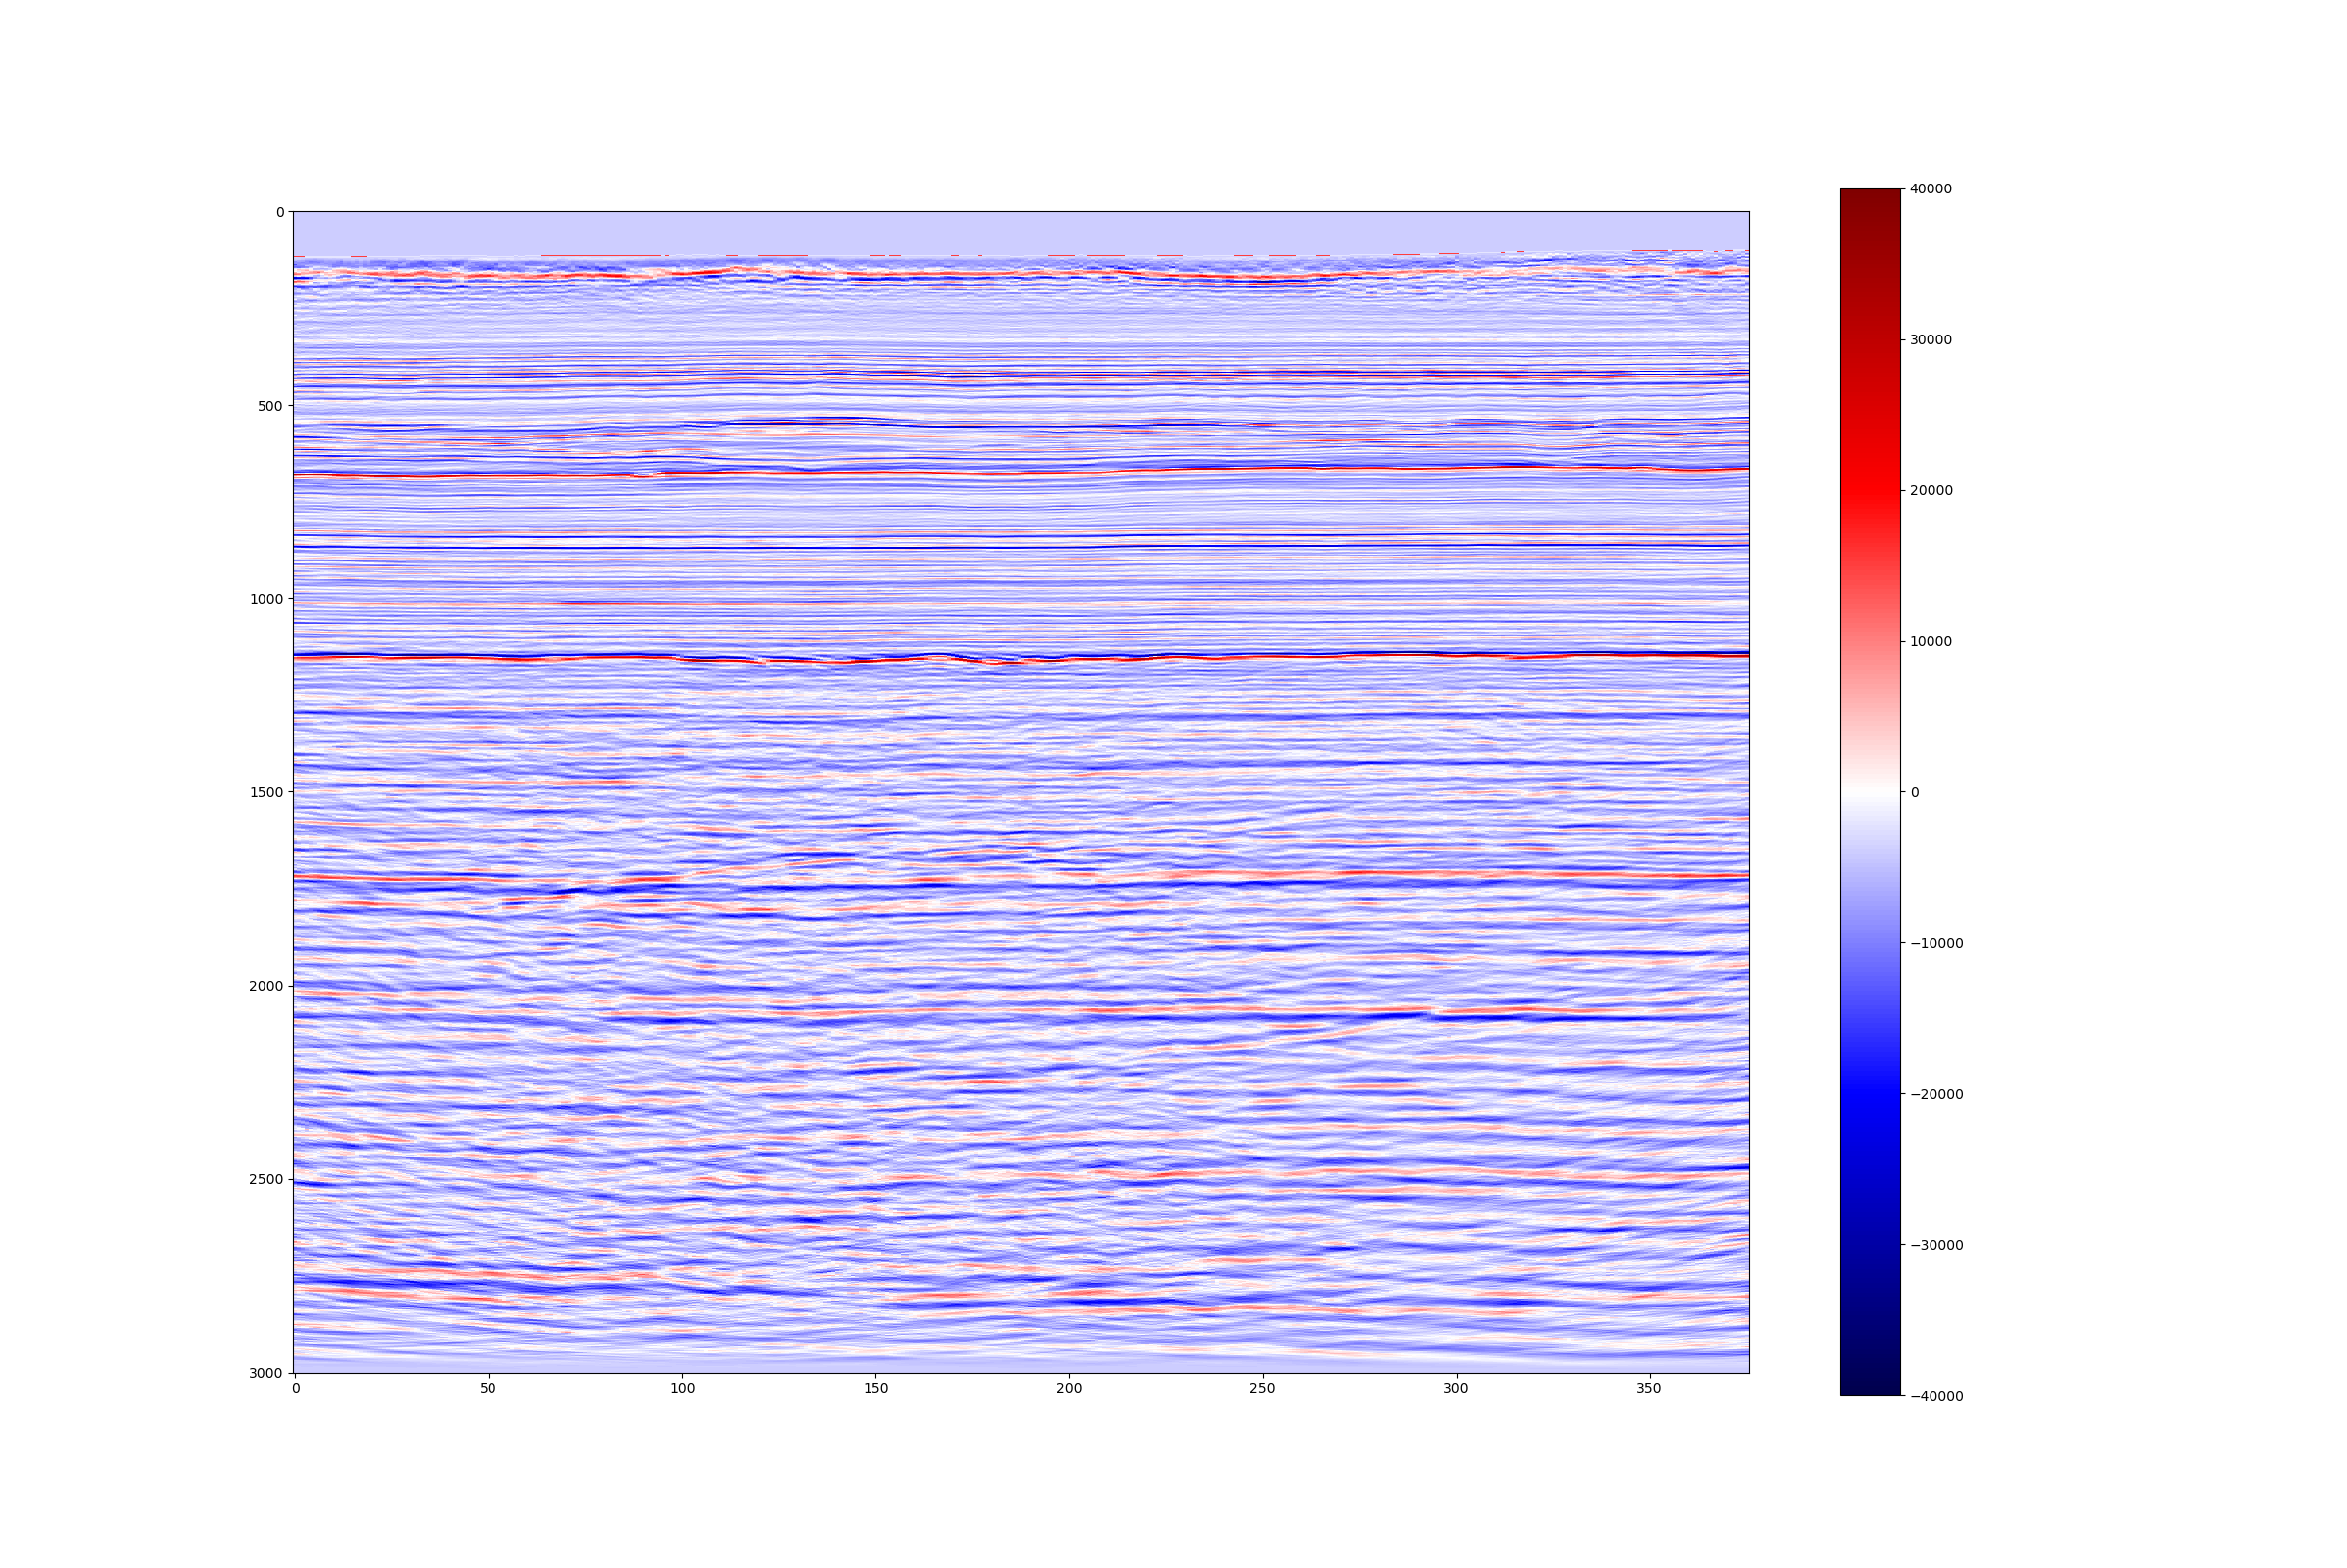

none:  Zline
none:  Zline
none:  Inline
none:  Inline
none:  Inline
none:  Inline


In [59]:
v1=VBox([c_update,auto_scale])
h1=HBox([graphtype,v1])#itrace,

#h1 = HBox([itrace,c_update,auto_scale])
h2= HBox([il_Slider,xl_Slider,z_Slider])
h3 = HBox([colormap,interpolation,filters])
h4= HBox([vmin,vmax,vert_ex])
h5= HBox([attribute,degree])
display(h1,h2,h3,h4,h5)

#right_box = VBox([items[2], items[3]])
#HBox([left_box, right_box])

#display(itrace,il_Slider,xl_Slider,z_Slider,colormap,interpolation,vmin,vmax,filters)#iBP,LB,HB,
il_plot(src.ilines[0],colormap.value,interpolation.value,clear=True)
t=1
#display(xl_Slider,colormap,interpolation)
#xl_plot(src.xlines[0],colormap.value,interpolation.value,changecmap=True)
#display(z_Slider,colormap,interpolation)
#z_plot(0,colormap.value,interpolation.value,changecmap=True)